In [29]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torchmetrics as tm
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt  # Import library for plotting
import numpy as np  # Import library for numerical computations
from collections import Counter  # Import Counter for counting elements


In [30]:
%load_ext tensorboard
%tensorboard --logdir logs

base_dir = '../datasets/cifar10'
batch_size_training = 500 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 4688), started 0:37:38 ago. (Use '!kill 4688' to kill it.)

Use GPU if available

In [31]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda:0" if train_on_gpu else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:0


# Data augmentation

# Data Augmentation

In [32]:
augmentation = transforms.Compose( #  it essentially a set of operations that are applied to the image, but it is not yet used. we're preparing a pipeline of transformations
    [
        transforms.RandomHorizontalFlip(p=0.5), 
        transforms.RandomResizedCrop(32, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), 
        transforms.RandomAffine(degrees=30, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0)
        
    ])
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[.485, .456, .406], std=[.229, .224, .225]),
     ])

aug_tranform = transforms.Compose([
        augmentation,
        transform
    ])

     # normalization of the pixel values for each channel

# Load the CIFAR10 dataset
trainset = torchvision.datasets.CIFAR10(root = base_dir, train=True, download=True, transform=aug_tranform) # download the dataset and apply the transformations

tempset = torchvision.datasets.CIFAR10(root = base_dir, train=False, transform=transform)
valset, testset = torch.utils.data.random_split(tempset, [1000, 9000]) # split the validation and test set
 
# Loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_training, shuffle=True, num_workers=8)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size_training, shuffle=False, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size_training, shuffle=False, num_workers=8)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified


Let us [show](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html#matplotlib-pyplot-imshow) some of the training images


Train loader:
100
{'frog': 5000, 'truck': 5000, 'deer': 5000, 'car': 5000, 'bird': 5000, 'horse': 5000, 'ship': 5000, 'cat': 5000, 'dog': 5000, 'plane': 5000}
torch.Size([500, 3, 32, 32])


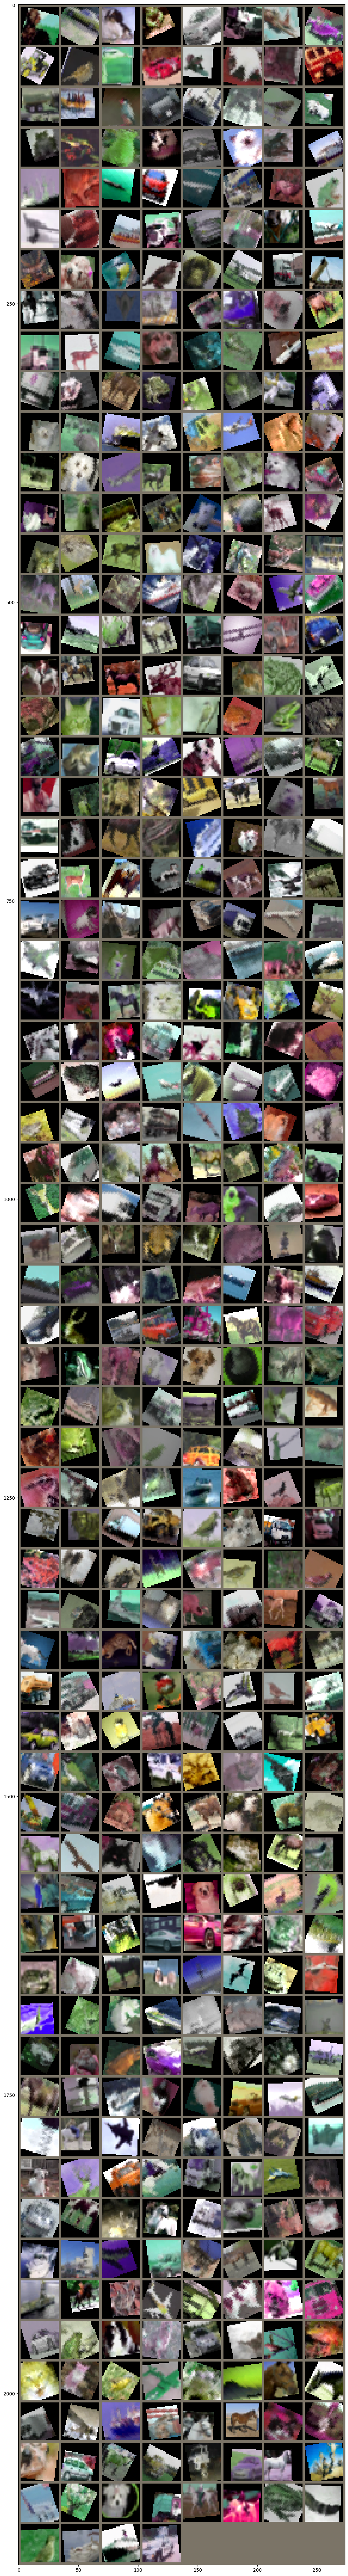

In [33]:
# Function to display an image
def imshow(image):
    mean=torch.tensor([0.485, 0.456, 0.406])
    std=torch.tensor([0.229, 0.224, 0.225])

    # Unnormalize the image channels to [0, 1]
    image = image.mul(std.unsqueeze(1).unsqueeze(2))  # More efficient element-wise multiplication
    image = image.add(mean.unsqueeze(1).unsqueeze(2))  # Efficient element-wise addition

    image= image.clamp(0, 1)

    # Convert the tensor to a NumPy array
    npimg = image.numpy()
    # Plot the image using matplotlib
    plt.figure(figsize=(30, 100))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose for correct display
    # plt.axes('off')
    plt.show()

# ------------------ Train Loader Section ------------------

print("Train loader:")

# Count the frequency of each class in the training set
stat = dict(Counter(trainset.targets))

# Create a new dictionary with class names as keys
new_stat = stat.copy()
for k in stat.keys():
    new_stat[classes[k]] = stat[k]
    del new_stat[k]

# Print the length of the train loader (number of batches)
print(len(trainloader))

# Print the class distribution in the training set
print(new_stat)

# Get a batch of random training images and their labels
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Print the shape of the image tensor (batch_size, channels, height, width)
print(images.shape)

# Display the images using the imshow function
imshow(torchvision.utils.make_grid(images))



# Definition of Networks

In [34]:
class CosoNet(nn.Module): # the initial weights are random
    def __init__(self):
        super(CosoNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 128, 3, 1, 1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(512, 734, 3, 1, 1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(734),
            nn.Conv2d(734, 734, 3, 1, 1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(734),
            nn.MaxPool2d(2, 2)
        )

        self.fc4 = nn.Sequential(
            nn.Linear(2936, 2048),
            nn.Dropout(.5),
            nn.LeakyReLU(),
        )

        self.fc5 = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.Dropout(.5),
            nn.LeakyReLU()
        )

        self.fc6 = nn.Linear(1024, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.shape[0], -1)
        x = self.fc4(x)
        x = self.fc5(x)
        x = self.fc6(x)
        return x

In [35]:
import torch
import torch.nn as nn

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.conv5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(.3),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(.5))
        self.fc2 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(.5)),
        
        self.fc2 = nn.Linear(4096, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.shape[0], -1) # Flatten the tensor
        x = self.fc(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [36]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.layer5 = nn.Sequential(
            nn.Linear(2048, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 10)
        )
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.shape[0], -1)
        x = self.layer5(x)
        return x

In [37]:
vgg16_net = VGG16()
alex_net = AlexNet()
coso_net = CosoNet()

In [38]:
sum(p.numel() for p in coso_net.parameters() if p.requires_grad), sum(p.numel() for p in alex_net.parameters() if p.requires_grad), sum(p.numel() for p in vgg16_net.parameters() if p.requires_grad)

(20938850, 20146762, 32850250)

# Visualize training augmentation examples

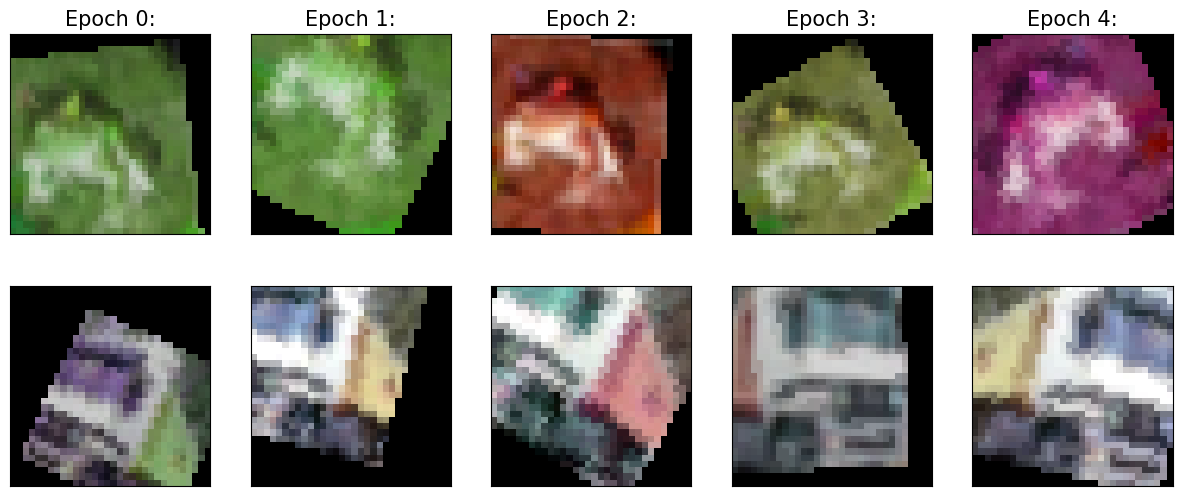

In [39]:
def im_transform(image):
    mean=torch.tensor([0.485, 0.456, 0.406])
    std=torch.tensor([0.229, 0.224, 0.225])

    # Unnormalize the image channels to [0, 1]
    image = image.mul(std.unsqueeze(1).unsqueeze(2))  # More efficient element-wise multiplication
    image = image.add(mean.unsqueeze(1).unsqueeze(2))  # Efficient element-wise addition

    image= image.clamp(0, 1)

    # Convert the tensor to a NumPy array
    npimg = image.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

data_loader = DataLoader(trainset, batch_size=2)
fig = plt.figure(figsize=(15, 6))
num_epochs = 5
for j in range(num_epochs):
    img_batch, label_batch = next(iter(data_loader))
    img = img_batch[0]
    ax = fig.add_subplot(2, 5, j + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Epoch {j}:', size=15)
    ax.imshow(im_transform(img))
    
    img = img_batch[1]
    ax = fig.add_subplot(2, 5, j + 6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(im_transform(img))
plt.show()


# Train the Network

In [40]:
def validation(net, val_loader):
    m_acc_macro = tm.Accuracy(task='multiclass', average='macro', num_classes=len(classes)).to(device)
    m_acc_micro = tm.Accuracy(task='multiclass', average='micro', num_classes=len(classes)).to(device)

    net.eval()
    with torch.no_grad():
        for el, gt in val_loader:
            el = el.to(device)
            gt = gt.to(device)
            out = net(el)
            m_acc_macro.update(out, gt)
            m_acc_micro.update(out, gt)

    return m_acc_macro.compute(), m_acc_micro.compute()



def load_checkpoint(filepath, model, optimizer):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return model, optimizer



def train(net, optimizer, criterion, epochs, patience, writer, resume_training=False):

    best_micro = 0
    rage = 0
    n_iter = 0
    
    if os.path.exists(f'{base_dir}/best_model.pth'):
        best_net, _ = load_checkpoint(f'{base_dir}/best_model.pth', net, optimizer)
        _, best_micro = validation(best_net, valloader)
        print(f"Best model loaded with micro: {best_micro}")
       
    

    if resume_training:
        try:
            net, optimizer = load_checkpoint(f'{base_dir}/last_model.pth', net, optimizer)
            print("Model loaded from last checkpoint.")
        except:
            print("No checkpoint found, starting from scratch.")

    for epoch in (range(epochs)):
        
        net.train()
        
        if rage >= patience:
            print("STAHP")
            break
        running_loss = 0.0

        for _, data in tqdm(enumerate(trainloader, 0)):
            
            inputs, gt = data
            
            inputs = inputs.to(device)
            gt = gt.to(device)

            optimizer.zero_grad()

            output = net(inputs)
            loss = criterion(output, gt)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()

            writer.add_scalar('Loss/train', loss.item(), n_iter)
            n_iter += 1

        macro, micro = validation(net, valloader)
        running_loss /= len(trainloader)
        print(f'Epoch: {epoch}, Train Loss: {running_loss}, Val Macro: {macro}, Val Micro: {micro}')
        writer.add_scalar('Loss/val', running_loss, epoch)
        writer.add_scalar('Accuracy/val_macro', macro, epoch)
        writer.add_scalar('Accuracy/val_micro', micro, epoch)
        if micro > best_micro:
            best_micro = micro
            torch.save({
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, f'{base_dir}/best_model.pth')
            rage = 0
        else:
            rage += 1
        torch.save({
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, f'{base_dir}/last_model.pth')


In [41]:
resume_training = True
net = coso_net # coso_net, alex_net, vgg16_net
epochs = 200
patience = 50

net.to(device)
writer = SummaryWriter('logs')
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)




train(net = net, optimizer = optimizer, criterion = criterion, epochs = epochs, patience = 50, writer = writer, resume_training = resume_training)

Model loaded from last checkpoint.


100it [00:12,  8.32it/s]


Epoch: 0, Train Loss: 1.1592256873846054, Val Macro: 0.7360002994537354, Val Micro: 0.7350000143051147


100it [00:12,  8.32it/s]


Epoch: 1, Train Loss: 0.9482799673080444, Val Macro: 0.7922713756561279, Val Micro: 0.7919999957084656


100it [00:12,  8.23it/s]


Epoch: 2, Train Loss: 0.8417406243085861, Val Macro: 0.7775590419769287, Val Micro: 0.7770000100135803


100it [00:12,  8.27it/s]


Epoch: 3, Train Loss: 0.7867686223983764, Val Macro: 0.7990199327468872, Val Micro: 0.800000011920929


100it [00:12,  8.26it/s]


Epoch: 4, Train Loss: 0.7326253932714463, Val Macro: 0.806214451789856, Val Micro: 0.8069999814033508


100it [00:12,  8.26it/s]


Epoch: 5, Train Loss: 0.6921006220579148, Val Macro: 0.817105770111084, Val Micro: 0.8169999718666077


100it [00:12,  8.22it/s]


Epoch: 6, Train Loss: 0.6545182025432587, Val Macro: 0.8326942920684814, Val Micro: 0.8320000171661377


100it [00:12,  8.14it/s]


Epoch: 7, Train Loss: 0.6149233084917068, Val Macro: 0.839975118637085, Val Micro: 0.8399999737739563


100it [00:12,  8.15it/s]


Epoch: 8, Train Loss: 0.6009652888774872, Val Macro: 0.8465173244476318, Val Micro: 0.8460000157356262


100it [00:12,  8.13it/s]


Epoch: 9, Train Loss: 0.5706852373480796, Val Macro: 0.8571423888206482, Val Micro: 0.8569999933242798


100it [00:12,  8.12it/s]


Epoch: 10, Train Loss: 0.5507938179373741, Val Macro: 0.8697675466537476, Val Micro: 0.8690000176429749


100it [00:12,  8.12it/s]


Epoch: 11, Train Loss: 0.5283273696899414, Val Macro: 0.8666859865188599, Val Micro: 0.8669999837875366


100it [00:12,  8.14it/s]


Epoch: 12, Train Loss: 0.5116329103708267, Val Macro: 0.8617435693740845, Val Micro: 0.8619999885559082


100it [00:12,  8.16it/s]


Epoch: 13, Train Loss: 0.542801802456379, Val Macro: 0.8494383096694946, Val Micro: 0.8500000238418579


100it [00:12,  8.14it/s]


Epoch: 14, Train Loss: 1.0527185326814652, Val Macro: 0.6681826114654541, Val Micro: 0.6660000085830688


100it [00:12,  8.20it/s]


Epoch: 15, Train Loss: 0.801555826663971, Val Macro: 0.8252857327461243, Val Micro: 0.824999988079071


100it [00:12,  8.20it/s]


Epoch: 16, Train Loss: 0.6120938611030579, Val Macro: 0.8448939323425293, Val Micro: 0.8450000286102295


100it [00:12,  8.19it/s]


Epoch: 17, Train Loss: 0.5407729053497314, Val Macro: 0.8500888347625732, Val Micro: 0.8500000238418579


100it [00:12,  8.18it/s]


Epoch: 18, Train Loss: 0.49679034411907197, Val Macro: 0.8714420795440674, Val Micro: 0.8709999918937683


100it [00:12,  8.19it/s]


Epoch: 19, Train Loss: 0.4955411866307259, Val Macro: 0.8601253628730774, Val Micro: 0.8600000143051147


100it [00:12,  8.17it/s]


Epoch: 20, Train Loss: 0.4580613097548485, Val Macro: 0.8731133937835693, Val Micro: 0.8730000257492065


100it [00:12,  8.18it/s]


Epoch: 21, Train Loss: 0.4333551374077797, Val Macro: 0.8773684501647949, Val Micro: 0.8769999742507935


100it [00:12,  8.21it/s]


Epoch: 22, Train Loss: 0.41704330414533614, Val Macro: 0.8681570887565613, Val Micro: 0.8679999709129333


100it [00:12,  8.23it/s]


Epoch: 23, Train Loss: 0.4103693515062332, Val Macro: 0.8695919513702393, Val Micro: 0.8690000176429749


35it [00:04,  7.79it/s]


KeyboardInterrupt: 

In [42]:
macro, micro = validation(net, testloader)

print(f'Test Macro: {macro}, Test Micro: {micro}')

Test Macro: 0.8725635409355164, Test Micro: 0.8726666569709778


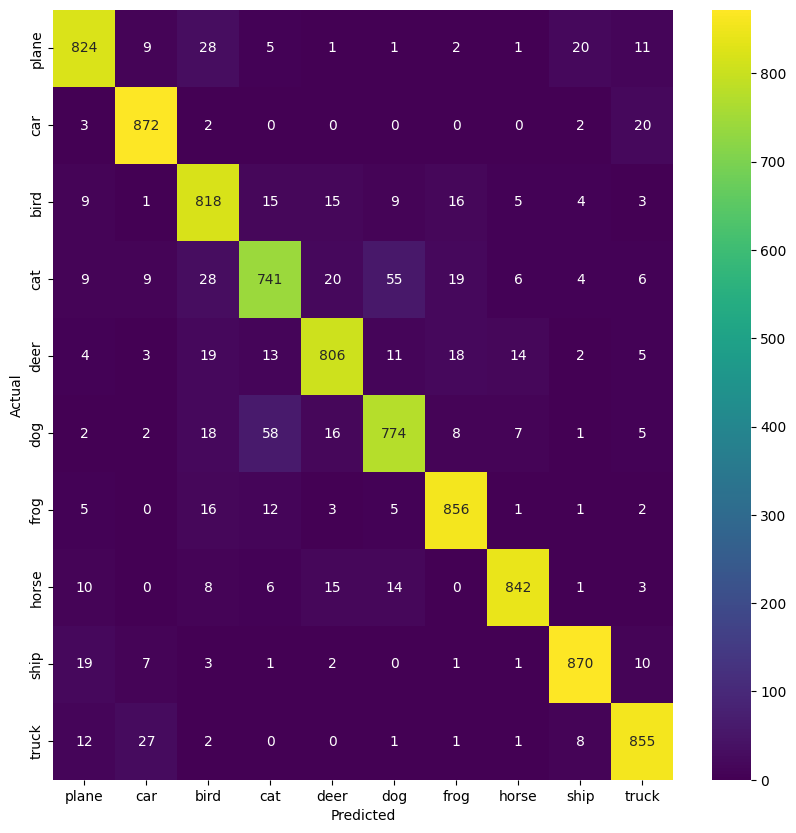

In [ ]:
def plot_confusion_matrix(net, test_loader):
    
    net.eval()
    gt = []
    pred = []
    with torch.no_grad():
        for el, labels in test_loader:
            el = el.to(device)
            labels = labels.to(device)
            out = net(el)
            _, predicted = torch.max(out, 1)
            gt.extend(labels.cpu().numpy())
            pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(gt, pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='g', cmap='viridis', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# best_net, _ = load_checkpoint(f'{base_dir}/best_model.pth', net, optimizer)
plot_confusion_matrix(net, testloader)


# Visualization of the network

In [ ]:
import torch
from torchviz import make_dot
# Plot model architecture

net = CosoNet()

# Create a dummy input
dummy_input = torch.randn(1, 3, 32, 32)

# Generate a visualization of the computational graph
dot = make_dot(net(dummy_input), params=dict(net.named_parameters()))
dot.render("model", format="png")  # Save the visualization to a file




'model.png'

In [ ]:
from torchsummary import summary
net.eval()
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           3,584
         LeakyReLU-2          [-1, 128, 32, 32]               0
       BatchNorm2d-3          [-1, 128, 32, 32]             256
            Conv2d-4          [-1, 128, 32, 32]         147,584
         LeakyReLU-5          [-1, 128, 32, 32]               0
       BatchNorm2d-6          [-1, 128, 32, 32]             256
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 256, 16, 16]         295,168
         LeakyReLU-9          [-1, 256, 16, 16]               0
      BatchNorm2d-10          [-1, 256, 16, 16]             512
           Conv2d-11          [-1, 256, 16, 16]         590,080
        LeakyReLU-12          [-1, 256, 16, 16]               0
      BatchNorm2d-13          [-1, 256, 16, 16]             512
        MaxPool2d-14            [-1, 25